<a href="https://colab.research.google.com/github/himalayahall/DATA602/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

Recently, there have been game-changing developments in Natural Language Processing (NLP), most notably the remarkable text generation capabilities of Large Language Models (LLMs) like ChatGPT. 

These developments are the driving motivation for this project to use NLP/LLM techniques for text classification and text generation.


- it would not be an overstatement to say these advances have taken the public imagination by storm.

- companies across all industry sectors are investing and exploring NLP in order to create new products and services using a natural language interface.


## Introduction

Language/text related subtopics of Machine Learning can be broadly broken down as follows:

- **NLP:** involves numerous tasks that break down natural language into smaller elements in order to understand the relationships between those elements and how they work together.

- **NLU:** uses syntactic and semantic analysis to determine the meaning of text.

- **NLG:** concerned with enabling machines to not just process and understand text but to generate text.

- **Large Language Model (LLM)**

- **Transfer Learning**


- **NLP:** NLP focuses largely on converting text to structured data. It does this through the identification of named entities (a process called named entity recognition or NER) and identification of word patterns, using methods like tokenization, stemming, and lemmatization, which examine the root forms of words.


- **NLU:** One of the primary goals of NLU is to teach machines how to interpret and understand language. It leverages algorithms to recognize attributes of language such as sentiment, semantics, context, and intent.


- **NLG:** NLG is the process of producing a human language text response based on some data input (prompt).


- **LLM:** A large language model (LLM) is a language model consisting of a neural network with many parameters (typically, billions of weights or more), trained on large quantities of unlabeled text using self-supervised or semi-supervised learning.


- **Transfer Learning:** enables using a pre-trained LLM as a baseline for a variety of machine learning tasks.


Some factors driving the proliferation of ML and NLP:

- **Large Language Models** (LLMs) emerged around 2018 and perform well at a wide variety of tasks such as machine translation, named entiry recognization (NER), sentiment analysis, summarization, text generation, etc. In this project we will use all these, implicitly and explicitly, to build a classifier for product reviews.

- **Transfer Learning** is a game changer and it allows pre-trained LLMs to be shared and leveraged for domain specific tasks with minimal incremental training. Instead of training a LLM from scratch developers can piggyback off a pre-trained model like ChatGPT.

- Modern frameworks like Tensorflow, PyTorch, Fastai, Tidymodels, and many others, together with cloud platforms such as Huggingface and Google Colab, have made it possible to build powerful ML applications with relatively modest effort.


## Dataset

* Motivation: Fake reviews are a major problem because they erode consumer confidence in the online marketplace. Companies spend considerable effort to identify and remove fake reviews.

* [Fake reviews dataset](https://osf.io/3vds7) contains 20K fake reviews and 20k real product reviews. 

* Review labels: OR = Original reviews (presumably human created and authentic), CG = Computer-generated fake reviews.


## Project goals

1. Build a classifier for product reviews using a base LLM.

2. Fine-tune the base LLM for product reviews.

3. Build a new classifier for product reviews using the fine-tuned LLM (hopefully, performs better than the first classifier).

4. Auto-generate reviews using the fine-tuned LLM.


### Tools and Frameworks

- Python

- [Fastai](https://fastai.github.io/fastbook2e/book10.html)

- Jupyter Notebook

- [nbconvert](https://nbconvert.readthedocs.io/en/latest/)

- Google Colab

We will use Deep Learning and LLM architectures for building a classifier to label product reviews as either original or fake. 

Transfer Learning - we use a LLM that was trained on Wikipedia as the base model for building the classifier. Transfer Learning is a great way to leverage pre-built LLMs without needing to do prohibitively expensive training from scratch.

Domain-specific LLM: The English language learned by the pretrained language model (using Wikipedia) is slightly different from the English used for product reviews. So, instead of jumping directly to the classifier, fine-tune the pretrained language model to the product corpus and use the new language model as the base for our classifier. This should (if all goes as well) result in better classifier performance.

Text generation: This will be done by giving the model some starting text (prompt) and asking the model to generate the rest (up to a maximum number of words). All text generation models require prompts, in fact prompt engineering is a an area of intense interest and research.


## Load data

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA602/main/fake%20reviews%20dataset.csv')

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


Data cleanup - drop *category* and *rating* columns, rename *text_* to *text*.

In [ ]:
df['text'] = df['text_']
df.drop(columns=['category', 'rating', 'text_'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   40432 non-null  object
 1   text    40432 non-null  object
dtypes: object(2)
memory usage: 631.9+ KB


In [ ]:
df.head()

,label,text
0,CG,"Love this! Well made, sturdy, and very comfor..."
1,CG,"love it, a great upgrade from the original. I..."
2,CG,This pillow saved my back. I love the look and...
3,CG,"Missing information on how to use it, but it i..."
4,CG,Very nice set. Good quality. We have had the s...


## Null model (baseline performance)

* For a perfectly **balanced** dataset (e.g. equal number of CG and OR), *accuracy* of the *Null* model is $50\%$.

* It provides guardrail - i.e. any model we build must have **higher accuracy**.

* *Null* model for  **always** predicts the majority class. For example, suppose a dataset for college admission contains $40\%$ acceptances and $60\%$ rejections. The *Null* model classifier for this dataset will always predict *rejection*, and it will have $accuracy = 60\%$.


Note: *accuracy* is **not** a good metric for **unbalanced datasets**. 


To evaluate classifier model performance it is important to have a baseline. This baseline, called the *Null* model, is the simplest possible classifier for a given dataset and acts as a guardrail during new model development. In a nutshell, any model worth deploying **must** perform better than the *Null* model

As a example example, data shows us that the prevalence of cancer in the general population in USA is roughly 5.5%. Accuracy of the *Null* model for such a dataset would be 94.5%. However, the *Null* model would be completely useless at detecting cancer (since it never predicts cancer)!

In [ ]:
cat_size = df.groupby('label').size()
print(cat_size)

prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , prop)

label
CG    20216
OR    20216
dtype: int64
Baseline (null model) accuracy:  0.5


## Model Performance - Accuracy

For a balanced dataset, Accuracy is perhaps the simplest and most intuitive performance metric for a binary classifier.

$CP = Number\ of\ Correct\ Predictions$

$IP = Number\ of\ Incorrect\ Predictions$

$Accuracy = \frac{CP}{CP + IP}$ 


## Other Performance Metrics

Some commonly used metrics:

- **Precision** ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$). 

$P = \frac{T_p}{T_p+F_p}$

- **Recall** ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p+F_n}$ 

- **F1 Measure**, is defined as the harmonic mean of precision and recall. It is a number in the range [0.0, 1.0], the closer it is to 1.0 the better the model.  

$F1 = 2 \frac{P \times R}{P+R}$

## ML Framework

We will use the [Fastai](https://fastai.github.io/fastbook2e/book10.html) framework to build a Large Language Model (LLM). 


Fastai is a great framework that enables rapid creation of predictive models without the need to write low level code in in frameworks like Tensorflow or PyTorch.

In [ ]:
from fastai.data.all import *
from fastai.text.all import *

## Create Classifier

Using the dataframe, build data loaders for classification.


In [ ]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('label'),
            splitter=TrainTestSplitter(test_size=0.2, 
                                       random_state=42
                                       #,stratify=df.label
                                       )
        ).dataloaders(df)

DataBlock is a generic container for quickly building data loaders.

Set aside 20% data using **TrainTestSplitter** for model testing.

**random_state** controls the shuffling applied to data before the split. Here it is set explicitly for reproducible output across multiple function calls

Since this dataset is perfectly balanced there is no need for stratification.


In [ ]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos i compared this rawhide to & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide - braided - sticks - for - dogs-7 - to-8 - inch-2 - count - pack - of-1 / dp / xxup b005gwvwja / ref = cm_cr_arp_d_rvw_txt?ie = utf8"">good xxmaj buddy xxup usa xxmaj rawhide xxmaj braided xxmaj sticks for xxmaj dogs , 7 to 8 - inch , 2 xxmaj count ( pack of 1 ) < / a > & for my 3 year old labradoodle . \n\n xxup where xxup it xxup is xxup made : xxmaj this is made in xxup china . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide -",OR
1,"xxbos xxmaj what is going on here . xxmaj first and most importantly , xxmaj this is not season three of scooby - doo . xxmaj seasons three and four was the scooby - doo movies , and seasons five thru seven is ' the scooby - doo xxmaj show ' which features scooby - xxunk . xxmaj here is all the episodes of seasons five thru seven . \n\n xxmaj season xxmaj five : \n 01 . a xxmaj bum xxmaj steer xxmaj for xxmaj scooby \n 02 . xxmaj the xxmaj gruesome xxmaj game xxmaj of xxmaj the xxmaj gator xxmaj xxunk \n 03 . xxmaj the xxmaj spirits of ' 76 \n 04 . xxmaj the xxmaj ghost xxmaj of xxmaj the xxmaj bad xxmaj humor xxmaj man \n xxunk . xxmaj the no - face xxmaj zombie xxmaj chase xxmaj case \n 06 . scooby -",OR
2,"xxbos xxrep 3 > … "" the xxmaj lean xxmaj startup : … "" is a "" mustread "" for those who use the xxmaj application of xxmaj lean xxmaj thinking to the xxmaj process of xxmaj innovation xxrep 3 ! … xxrep 3 > xxmaj eric xxmaj xxunk , xxmaj entrepreneur , xxmaj authority , xxmaj thought / xxmaj team xxmaj leader & xxmaj author , etc . has put together xxunk + pages , 3 xxmaj parts , 14 xxmaj chapters of xxmaj knowledge , xxmaj context , xxmaj content , etc . applied to "" the xxmaj lean xxmaj startup "" xxrep 3 ! … < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / the - lean - startup - how - today - s - entrepreneurs - use - continuous - innovation - to - create",OR
3,"xxbos xxup ecw xxmaj extreme xxmaj evolution \n i had never seen any xxup ecw before buying this , but this is what i thought of it … \n xxup rvd v xxmaj jerry xxmaj lynn \n xxmaj this is a good match , although it takes a while to get started because of xxup rvd xxunk . xxmaj when it does though , the match makes up for the slow start . xxmaj there 's a nice table spot and lots of chairs . 7 / 10 \n xxmaj awesome v xxmaj xxunk \n xxmaj the best match on the xxup dvd . 2 tables break and lots of chairs are used ! xxmaj there are some good bumps and lots of high - flying moves too . i was surprised at how good this was . 8 / 10 \n xxmaj xxunk wire xxmaj match xxmaj raven v",OR
4,"xxbos xxmaj the xxmaj secret xxmaj life of xxmaj walter xxmaj mitty is a book for xxunk , lovers and the xxunk boy in all of us . i lived at home until i was a vine - xxunk 27 , so believe me i can relate to xxmaj james xxmaj xxunk xxmaj mitty . xxmaj and xxmaj i ve always been a fond of a good daydream . xxmaj lets see what comes to me now : \n\n xxmaj i m a powerful land baron with an eye patch . xxmaj nay , a xxunk samurai lord . xxmaj no , xxmaj i m an oil tycoon . xxmaj fabulously rich , silver - haired , xxunk - eyed and what s this ? xxmaj i m in turbulent fight with my lover , no my sister , no my lover and her xxunk son . xxmaj he has",OR


### Text Classifier

Create a text classifier using [AWD_LST]([https://arxiv.org/pdf/1708.02182.pdf]) (averaged weight-dropped long-short term memory) LLM.

In [ ]:
learner = text_classifier_learner(
                dls_cls, 
                AWD_LSTM, 
                metrics=[accuracy, Precision(), Recall(), F1Score()])

Before training the classifier we calculate the optimal learning rate. 

Learning rate, a key hyper-parameter, determines the step size at each iteration while moving toward a minimum of a loss function. 

This will greatly influence how quickly the model converges.

SuggestedLRs(valley=0.00363078061491251)

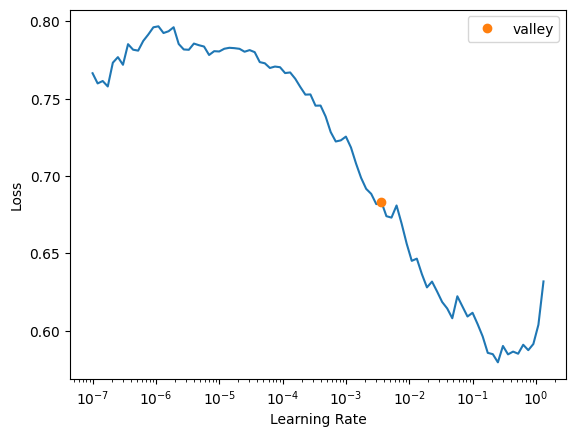

In [ ]:
lr = learner.lr_find()
lr

Fine tune model for 3 epochs using optimal learning rate.

In [ ]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.373153,0.386125,0.841721,0.921474,0.749447,0.826605,01:13


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.255537,0.355370,0.881415,0.981138,0.779415,0.868720,02:27
1,0.216305,0.218795,0.916904,0.987102,0.845984,0.911111,02:27
2,0.191615,0.238240,0.917275,0.992472,0.842054,0.911096,02:25


In [ ]:
learner_interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
learner_interp.print_classification_report()

              precision    recall  f1-score   support

          CG       0.86      0.99      0.92      4016
          OR       0.99      0.84      0.91      4071

    accuracy                           0.92      8087
   macro avg       0.93      0.92      0.92      8087
weighted avg       0.93      0.92      0.92      8087



## Model performance

- $accuracy = 92\%$, which is significantly higher than the *Null* model ($50\%$). 

- *Precision* is high for OR ($99\%$), lower for CG ($86\%$)

- *Recall* is high for CG ($99\%$), lower for OR ($84\%$).

- Overall, these are great performance numbers and will be hard to beat!

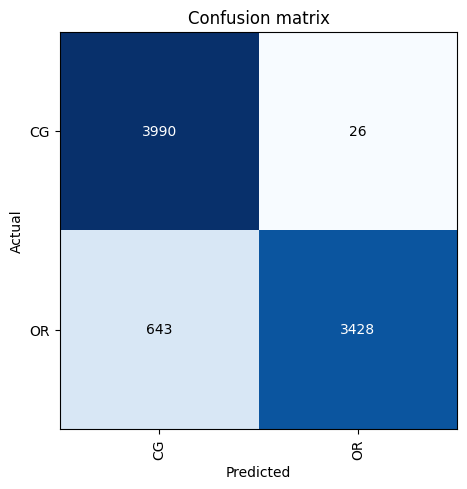

In [ ]:
learner_interp.plot_confusion_matrix()

The confusion matrix shows the model is misclassifying a much larger number of ORs (original reviews) compared to CGs (computer generated).

## Saving and loading model

At this point, if we wanted, we could save the model and it's trained weights. Later, the saved model could be loaded for making predictions.

In [ ]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [ ]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

To build this classifier we used a pretrained language model (AWD_LSTM). It was pretrained on Wikipedia English on the task of guessing the next word, after reading all previous words (within a fixed length window). 

Previouly, we got great results by directly fine-tuning this language model to build a product review classifier, but can we do even better?

Notice, we are glossing over the details of exactly how many words are considered in making the prediction, what is the $loss function$, which $optimizer$ to use to fit the model, etc. Good news is Fastai selects defaults for all these paramaters and more.

In general, with one extra step, we *might* do better: Wikipedia English is slightly different from the English in our review corpus. We might want to **fine-tune** the pretrained language model to the review corpus and use that to build our classifier.

Create the data loader for language modeling by setting $is\_lm=True$ . We set aside 10% data using **RandomSplitter** for model validation.

In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(
                        text_cols=('text'), 
                        is_lm=True),
                get_x=ColReader('text'), 
                splitter=RandomSplitter(valid_pct=0.1, seed=12345)
                ).dataloaders(df, bs=64)

In [ ]:
dls_lm.show_batch(max_n = 5)

,text,text_
0,"xxbos i loved it great variety of characters and the writing style was great . i really enjoyed this book.i read this book in the last few days and have enjoyed it xxbos xxmaj nice , affordable base sets that work well with xxmaj lego , xxup kre - o , etc . xxbos i read very little fiction but as an older friend said it is a "" pot xxunk .","i loved it great variety of characters and the writing style was great . i really enjoyed this book.i read this book in the last few days and have enjoyed it xxbos xxmaj nice , affordable base sets that work well with xxmaj lego , xxup kre - o , etc . xxbos i read very little fiction but as an older friend said it is a "" pot xxunk . xxunk"
1,covers ever since i bought it . i bought this for my daughter 's room and it 's been a good xxbos i do n't write well and this book kept me on my toes . xxmaj there were a few typos and mistakes but the story kept me interested xxbos xxmaj educational and fun toy . i recommend it.my son loves this toy . xxmaj he loves the music and the,ever since i bought it . i bought this for my daughter 's room and it 's been a good xxbos i do n't write well and this book kept me on my toes . xxmaj there were a few typos and mistakes but the story kept me interested xxbos xxmaj educational and fun toy . i recommend it.my son loves this toy . xxmaj he loves the music and the lights
2,"a decent blade , gets the job done - cuts aluminum . xxmaj it came nicely packaged in thick cardboard "" sleeve "" , with clear tubing protecting the teeth . 5 stars for packaging . \n xxmaj at my place , it will be used now and then for thin aluminum angle and strips . \n xxmaj cuts are not clean , i have to use a file to clean them","decent blade , gets the job done - cuts aluminum . xxmaj it came nicely packaged in thick cardboard "" sleeve "" , with clear tubing protecting the teeth . 5 stars for packaging . \n xxmaj at my place , it will be used now and then for thin aluminum angle and strips . \n xxmaj cuts are not clean , i have to use a file to clean them up"
3,"better looking than the plastic ones xxmaj i 've had before . xxmaj it looks like a decor piece instead of pet fountain , which makes me feel less like a crazy cat lady . xxmaj and xxmaj emily , my cat , has already approved it . xxmaj i 'm keeping my fingers crossed and hope it will last a long time . xxbos i loved this book so much .","looking than the plastic ones xxmaj i 've had before . xxmaj it looks like a decor piece instead of pet fountain , which makes me feel less like a crazy cat lady . xxmaj and xxmaj emily , my cat , has already approved it . xxmaj i 'm keeping my fingers crossed and hope it will last a long time . xxbos i loved this book so much . xxmaj"
4,"film to anyone who wants a complete set of movies.i love this show . i have watched the entire series several times . i am so happy to have all of the seasons . xxmaj this is a great show and is on my top 10 favorite shows of all time . i highly recommend this show . i would highly recommend this show . xxbos xxmaj this is called "" thor","to anyone who wants a complete set of movies.i love this show . i have watched the entire series several times . i am so happy to have all of the seasons . xxmaj this is a great show and is on my top 10 favorite shows of all time . i highly recommend this show . i would highly recommend this show . xxbos xxmaj this is called "" thor """


Next we create a language model learner using Perplexity metric to track LLM performance (how well the language model predicts a sample). Lower is better.

In [ ]:
lm_learner = language_model_learner(
                dls_lm, 
                AWD_LSTM, 
                wd=0.1,
                metrics=[Perplexity()]).to_fp16()

Once again, find the optimal learning rate.

SuggestedLRs(valley=0.001737800776027143)

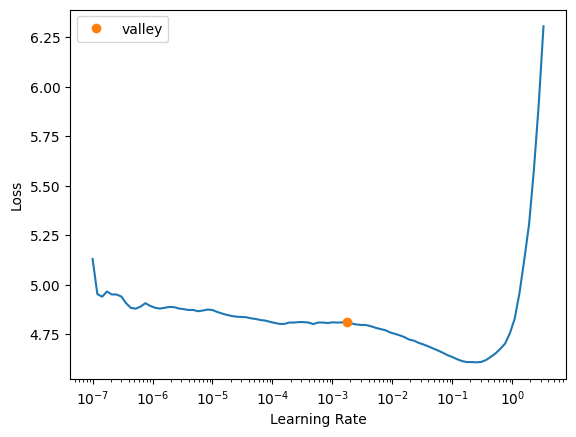

In [ ]:
lr = lm_learner.lr_find()
lr

Train the model for 1 epoch. By default, a pretrained Learner is in a *frozen* state, meaning that only the head of the model will train while the body stays frozen 

As a result, the pretrained language model is kept intact. This is the essence of of **transfer learning**.

In [ ]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.873621,3.566238,35.383221,02:36


Save model after 1 epoch.

In [ ]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Next, we unfreeze all layers of model for futher tuning.

In [ ]:
lm_learner.unfreeze()

As before, find the optimal learning rate.

SuggestedLRs(valley=0.0003981071640737355)

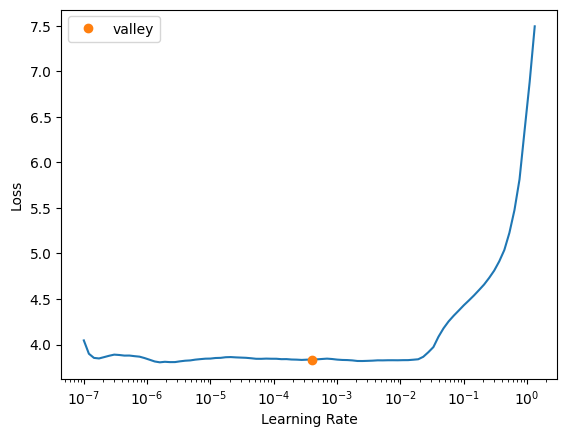

In [ ]:
lr = lm_learner.lr_find()
lr

Train language model for 3 epochs.

In [ ]:
lm_learner.fit_one_cycle(3, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.485900,3.252466,25.854015,02:44
1,3.337689,3.136334,23.019327,02:44
2,3.264591,3.117341,22.586233,02:48


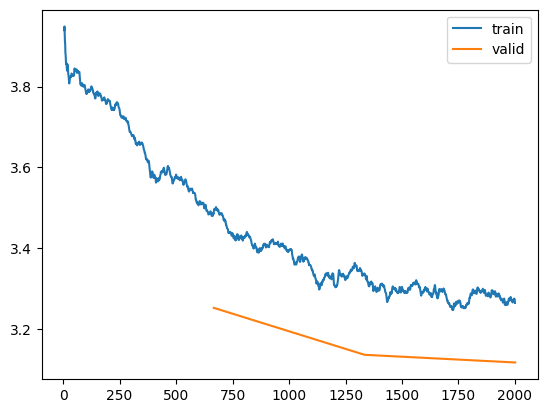

In [ ]:
lm_learner.recorder.plot_loss()

Now we save all of our model **except** the final layer that converts activations to probabilities of picking each token in our vocabulary. 

The model, not including the final layer, is called the **encoder**.

In [ ]:
lm_learner.save_encoder('finetuned')

Now we will use the new LLM to build another classifier with the hope of beating the previous classifier.

Create DataLoaders for classification using the domain specific language model. Notice, we set $is\_lm=False$ and use the vocabulary list from the LLM by setting $vocab=dls\_lm.vocab$.

In [ ]:
dls_cls = DataBlock(
            blocks=(
                    TextBlock.from_df(text_cols=('text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
                    CategoryBlock
                    ),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
            splitter=RandomSplitter(valid_pct=0.2, 
                                    seed=12345)
            ).dataloaders(df, bs=64)

Create text classification learner, using the new LLM as the encoder.

In [ ]:
llm_learn = text_classifier_learner(
                dls_cls, 
                AWD_LSTM, 
                metrics=[accuracy, Precision(), Recall(), F1Score()])
llm_learn = llm_learn.load_encoder('finetuned')

Find the optimal learning rate.

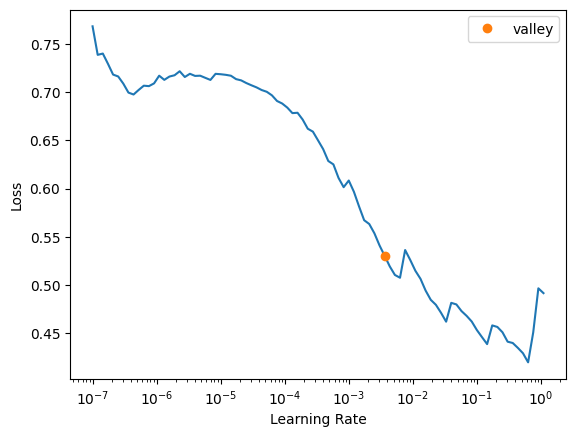

In [ ]:
lr = llm_learn.lr_find()

Tune model for 3 epochs.

In [ ]:
llm_learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.244453,0.161761,0.936062,0.946749,0.922885,0.934664,01:13


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.186865,0.120941,0.956221,0.947562,0.965061,0.956231,02:27
1,0.131349,0.103125,0.963146,0.960974,0.964812,0.962889,02:26
2,0.092955,0.085086,0.967227,0.981720,0.951585,0.966417,02:34


In [ ]:
llm_learn_interp = ClassificationInterpretation.from_learner(llm_learn)

In [ ]:
llm_learn_interp.print_classification_report()

              precision    recall  f1-score   support

          CG       0.95      0.98      0.97      4079
          OR       0.98      0.95      0.97      4007

    accuracy                           0.97      8086
   macro avg       0.97      0.97      0.97      8086
weighted avg       0.97      0.97      0.97      8086



 ## New model performance

- $accuracy = 97\%$, which is significantly higher than the previous model ($92\%$). 

- *Precision* is slightly lower for OR ($98\%$ versus $99\%$), higher for CG ($95\%$ versus $86\%$)

- *Recall* is slightly lower for CG ($98\%$ versus $99\%$), higher for OG ($95\%$ versus $84\%$).


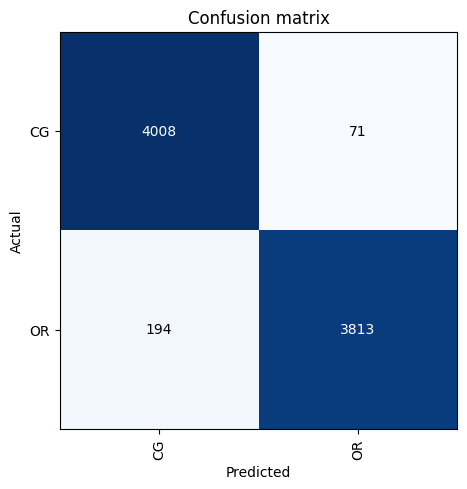

In [ ]:
llm_learn_interp.plot_confusion_matrix()

 The confusion matrix shows the new model has much better performance overall (265 total missclassifications versus 669 for previous model). 
 
 However, it's worth noting that while the previous model misclassified 26 CGs, the new model misclassified 71 CGs.

**Text Generation**

Use the new LLM for text generation (NLG). Text generation involves prompting the model with some text and asking the model to generate additional text.

 Sample prompts are actual *Amazon* reviews for different products.

In [ ]:
N_WORDS = 30
temperature = 0.75
PROMPTS = ["My husband is hard of hearing and would have a difficult time underdstaning", 
           "I have never encountered such an easy method of assembling", 
           "The quality is top"]

preds = [lm_learner.predict(p, N_WORDS, temperature=temperature) for p in PROMPTS]

for idx in range(len(PROMPTS)):
  print(f'{idx}: {preds[idx]}')

0: My husband is hard of hearing and would have a difficult time xxunk this one . He wears it every day and the only problem is that it 's kind of hard to put on . It 's not very durable
1: i have never encountered such an easy method of assembling my new drill so i will say that it has a very strong feel . It is not the best saw i have in my house . I
2: The quality is top notch and the design is very comfortable . Great quality . i am very pleased with the quality of the product . i am very happy with the purchase


One could play with a number of parameters to fine-tune the generated text, e.g. *temperature*, to get different results.

One could also experiment with hyper-parameters during model building, e.g. number of words to consider for predicting next word, regularization, etc.

## Conclusion

Through the implementation of this project we have explored NLP, NLU, and NLG concepts using Fastai.

We have fine-tuned a base LLM model and used it to build a classifier with better performance than a classifier built with the base LLM. The new LLM is also capable of text generation. 

Happy exploration and development!

The ability to build domain specific LLMs using transfer learning, on low-cost cloud infrastructutre, is a game changer that makes ML/NLP innovation available to a vast number of developers.

Although outside the scope of this project, it's worth mentioning that serious concerns have been rasied within and outside the AI scientific community about dangers posed by the rapid advancements in LLMs and the proliferation of AI:

- should we let machines flood our information channels with propaganda and untruth?

- should we automate away all the jobs, including the fulfilling ones?

- should we develop nonhuman minds that might eventually outnumber, outsmart, obsolete and replace us?

- should we risk loss of control of our civilization?

Some have proposed a [6-month pause](https://futureoflife.org/open-letter/pause-giant-ai-experiments) in the developoment

